In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage import io

In [2]:
cells1 = mpimg.imread('./cellMovement.tif')
cells2 = io.imread('./cellMovement.tif')

print(cells1.shape)
print(cells2.shape)

(720, 758)
(61, 720, 758)


In [3]:
import glob

fileList = glob.glob('./cellMovement/*.png')
cells2 = np.array([np.array(mpimg.imread(fname)) for fname in fileList])

print(cells2.shape)

(61, 720, 758)


0.0
1.0


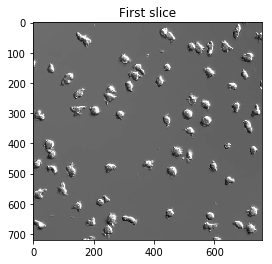

In [4]:
print(cells2.min())
print(cells2.max())

plt.imshow(cells2[1],cmap='gray')
plt.gca().set_title('First slice')

plt.show()

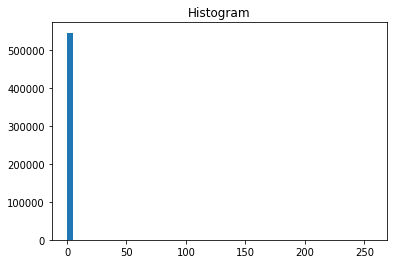

In [5]:
plt.hist(cells2[1].ravel(), bins=np.linspace(0, 256))
plt.gca().set_title('Histogram')

plt.show()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


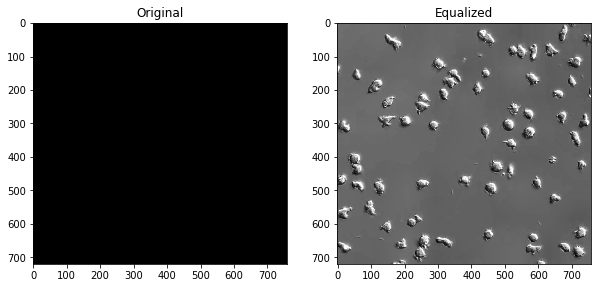

In [6]:
from skimage.exposure import equalize_adapthist

slice1EQ = equalize_adapthist(cells2[1],clip_limit=0.01)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.gca().set_title("Original")
plt.imshow(cells2[1], cmap='gray')
plt.clim(0,255)
plt.subplot(122)
plt.gca().set_title("Equalized")
plt.imshow(slice1EQ, cmap='gray')
plt.clim(0, 1)


plt.show()

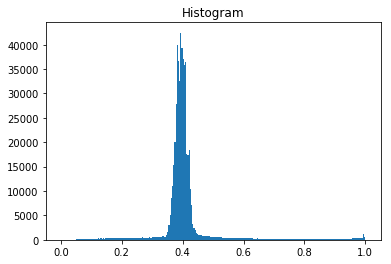

In [7]:
plt.hist(slice1EQ.ravel(), bins=np.linspace(0, 1, 256))
plt.gca().set_title('Histogram')

plt.show()

0.575716198582
0.0


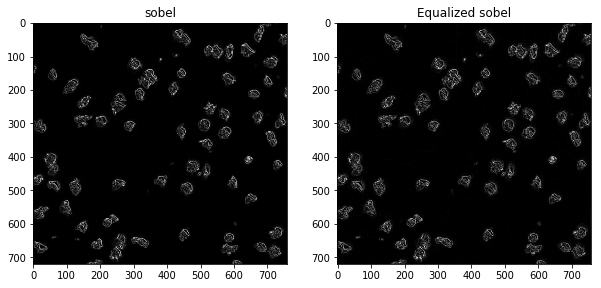

In [8]:
from skimage.filters import sobel

slice1EQSo = sobel(slice1EQ)
slice1So = sobel(cells2[1])

print(slice1EQSo.max())
print(slice1EQSo.min())


plt.figure(figsize=(10,5))
plt.subplot(121)
plt.gca().set_title("sobel")
plt.imshow(slice1So, cmap='gray')
plt.subplot(122)
plt.gca().set_title("Equalized sobel")
plt.imshow(slice1EQSo, cmap='gray')


plt.show()


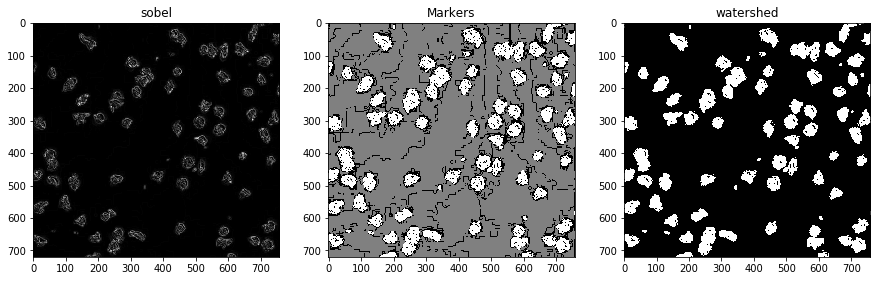

In [19]:
from skimage.morphology import watershed

markers = np.zeros_like(slice1EQSo)

markers[slice1EQSo > 0.04*np.max(slice1EQSo)] = 2
markers[slice1EQSo < 0.008*np.max(slice1EQSo)] = 1

slice1Ws = watershed(slice1EQSo, markers)

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.gca().set_title("sobel")
plt.imshow(slice1EQSo, cmap='gray')
plt.subplot(132)
plt.gca().set_title("Markers")
plt.imshow(markers, cmap='gray')
plt.subplot(133)
plt.gca().set_title("watershed")
plt.imshow(slice1Ws, cmap='gray')


plt.show()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/skimage/morphology/misc.py:203: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  "Did you mean to use a boolean array?", UserWarning)


There are 65 cells in this image.


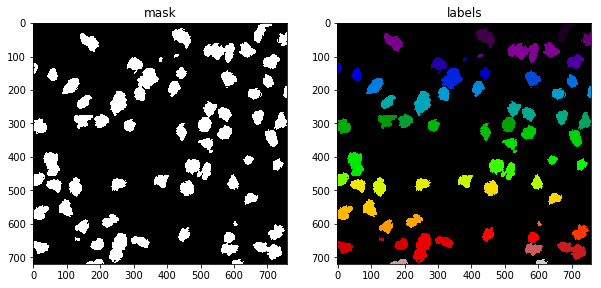

In [23]:
from skimage.morphology import remove_small_holes, remove_small_objects
import scipy.ndimage as ndi


slice1Mask = remove_small_objects(remove_small_holes(
    slice1Ws-1,area_threshold=100),min_size=130)
labels, nblabels = ndi.label(slice1Mask)
print("There are %d cells in this image." % nblabels)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.gca().set_title("mask")
plt.imshow(slice1Mask, cmap='gray')
plt.subplot(122)
plt.gca().set_title("labels")
plt.imshow(labels, cmap='nipy_spectral')


plt.show()

67


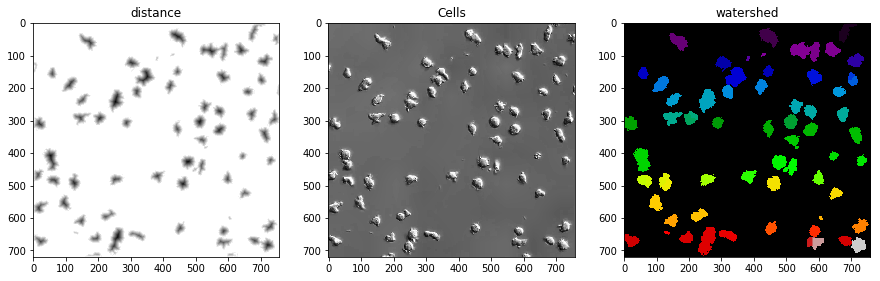

In [24]:
from skimage.feature import peak_local_max

distances = ndi.distance_transform_edt(slice1Mask)
local_maxi = peak_local_max(distances, indices=False, 
                            footprint=np.ones((36, 36)),labels=slice1Mask)

markers = ndi.label(local_maxi)[0]
labels = watershed(-distances, markers, mask=slice1Mask)

print(labels.max())
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.gca().set_title("distance")
plt.imshow(-distances, cmap='gray')
plt.subplot(132)
plt.gca().set_title("Cells")
plt.imshow(slice1EQ, cmap='gray')
plt.subplot(133)
plt.gca().set_title("watershed")
plt.imshow(labels, cmap='nipy_spectral')


plt.show()



In [20]:
def segmentCells(imIn):
    # This function segments cells using edge detection and
    # Two rounds of segmentation using the watershed algorithm
    
    # First detect edges using a sobel filter
    iminSo = sobel(imIn)
    
    # Calculate markers for seperating bg and fg
    markers = np.zeros_like(iminSo)

    markers[iminSo > 0.04*np.max(iminSo)] = 2
    markers[iminSo < 0.008*np.max(iminSo)] = 1

    # perform first watershed
    iminWs = watershed(iminSo, markers)
    Ws1Mask = remove_small_objects(remove_small_holes(iminWs-1,
                                    area_threshold=100),min_size=130)
    labels, nblabels = ndi.label(Ws1Mask)
    
    print("Number of cells found in first segmentation: ",nblabels)
    
    # Use the Ws1Mask to refine segmentation
    distances = ndi.distance_transform_edt(Ws1Mask)
    local_maxi = peak_local_max(distances, indices=False, 
                        footprint=np.ones((36, 36)),labels=slice1Mask)

    markers = ndi.label(local_maxi)[0]
    Ws2labels = watershed(-distances, markers, mask=Ws1Mask)
    
    print("Number of cells found in second segmentation: ",Ws2labels.max())
    
    return Ws2labels
    
    

    

In [25]:
newLabels = segmentCells(slice1EQ)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/skimage/morphology/misc.py:203: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  "Did you mean to use a boolean array?", UserWarning)


Number of cells found in first segmentation:  65
Number of cells found in second segmentation:  67


In [14]:
from skimage.measure import regionprops

cellRegions = regionprops(newLabels)

for prop in cellRegions:
    y0, x0 = prop.centroid
    print("Cell coordinates are: ", y0, x0)
    

Cell coordinates are:  26.1354091238 678.99275887
Cell coordinates are:  42.385127636 444.329078801
Cell coordinates are:  48.2898089172 158.145435244
Cell coordinates are:  67.1107954545 179.339488636
Cell coordinates are:  69.6569343066 591.233576642
Cell coordinates are:  90.9328018223 583.0261959
Cell coordinates are:  81.547267356 638.199409158
Cell coordinates are:  80.3142626914 530.698630137
Cell coordinates are:  91.378742515 554.173652695
Cell coordinates are:  115.462627852 710.172305271
Cell coordinates are:  120.720238095 293.037698413
Cell coordinates are:  116.754716981 303.028301887
Cell coordinates are:  125.160683761 312.979487179
Cell coordinates are:  149.374626866 442.650746269
Cell coordinates are:  153.949257426 58.7042079208
Cell coordinates are:  166.262927257 342.632778265
Cell coordinates are:  165.670015456 583.197063369
Cell coordinates are:  166.338709677 697.52764977
Cell coordinates are:  182.177718833 702.912466844
Cell coordinates are:  188.033806626 1

In [15]:
cellLocations = np.zeros((2,71))
count = 0

for prop in cellRegions:
    y0, x0 = prop.centroid
    cellLocations[0,count] = y0
    cellLocations[1,count] = x0
    count += 1


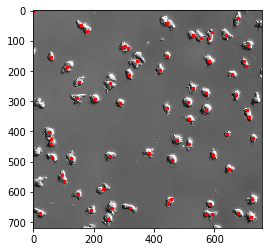

In [16]:

fig, ax = plt.subplots()
ax.imshow(slice1EQ, cmap=plt.cm.gray)
ax.plot(cellLocations[1,:], cellLocations[0,:], '.r', markersize=5)

plt.show()

In [17]:
for i in range(0,61):
    
    fileName = 'Frame' + str(i) + '.png'
    sliceEQ = equalize_adapthist(cells2[i],clip_limit=0.01)
    imLabels = segmentCells(sliceEQ)
    
    cellRegions = regionprops(imLabels)
    
    cellLocations = np.zeros((2,imLabels.max()))
    count = 0

    for prop in cellRegions:
        y0, x0 = prop.centroid
        cellLocations[0,count] = y0
        cellLocations[1,count] = x0
        count += 1
    
    fig, ax = plt.subplots()
    ax.imshow(sliceEQ, cmap=plt.cm.gray)
    ax.plot(cellLocations[1,:], cellLocations[0,:], '.r', markersize=5)

    plt.savefig(fileName,dpi=200)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/skimage/morphology/misc.py:203: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  "Did you mean to use a boolean array?", UserWarning)


Number of cells found in first segmentation:  60
Number of cells found in second segmentation:  65
Number of cells found in first segmentation:  64
Number of cells found in second segmentation:  68
Number of cells found in first segmentation:  61
Number of cells found in second segmentation:  69
Number of cells found in first segmentation:  61
Number of cells found in second segmentation:  68
Number of cells found in first segmentation:  60
Number of cells found in second segmentation:  62
Number of cells found in first segmentation:  56
Number of cells found in second segmentation:  62
Number of cells found in first segmentation:  62
Number of cells found in second segmentation:  67
Number of cells found in first segmentation:  62
Number of cells found in second segmentation:  53
Number of cells found in first segmentation:  59
Number of cells found in second segmentation:  53
Number of cells found in first segmentation:  59
Number of cells found in second segmentation:  48
Number of 

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Number of cells found in first segmentation:  60
Number of cells found in second segmentation:  42
Number of cells found in first segmentation:  59
Number of cells found in second segmentation:  37
Number of cells found in first segmentation:  60
Number of cells found in second segmentation:  45
Number of cells found in first segmentation:  57
Number of cells found in second segmentation:  38
Number of cells found in first segmentation:  55
Number of cells found in second segmentation:  41
Number of cells found in first segmentation:  55
Number of cells found in second segmentation:  36
Number of cells found in first segmentation:  59
Number of cells found in second segmentation:  42
Number of cells found in first segmentation:  57
Number of cells found in second segmentation:  38
Number of cells found in first segmentation:  51
Number of cells found in second segmentation:  40
Number of cells found in first segmentation:  49
Number of cells found in second segmentation:  45
Number of 